## **Import Library and Read Data**

In [1]:
#Import Library

#utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from itertools import product

#preprocessing
from sklearn.preprocessing import MinMaxScaler

#modelling
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2

print('success import library')

success import library


In [2]:
#setup seed for all python package
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#read data
train = pd.read_csv('TrainingUSD.csv', header=None, names=['Value'])
train.head(5)

,Value
0,14531.50000
1,14426.79981
2,14431.00000
3,14435.20020
4,14458.79981


**Explanation:** The data used is USD to IDR time series data, with a total sample of 200 training data

## **Simple Analysis**

In [4]:
#check data type
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   200 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [5]:
#check missing value
print(f'Missing values found: {train.isna().sum().sum()}\n')

Missing values found: 0



In [6]:
#check Statistics descriptive
train.describe()

,Value
count,200.000000
mean,15170.856495
std,338.540783
min,14426.799810
25%,14891.749760
50%,15141.500000
75%,15529.200195
max,15789.000000


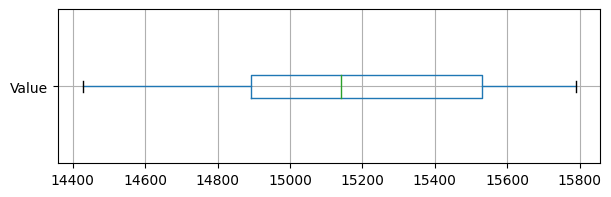

In [7]:
#check boxplot
train.boxplot(vert=False, figsize=(7, 2))
plt.show()

**Explanation:** Based on the results of the descriptive analysis and the plots of the boxplot data, for regression problem on time series data that has no outliers and does not need to follow the assumptions of a standard normal distribution, the Min-Max Scaling method can be the right choice.

## **Preprocessing Data**

In [8]:
#scaling with min max
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = scaler.fit_transform(train)
train_scaled = pd.DataFrame(train_scaled, columns=['Value'])
train_scaled.head(5)

,Value
0,0.076861
1,0.000000
2,0.003083
3,0.006167
4,0.023491


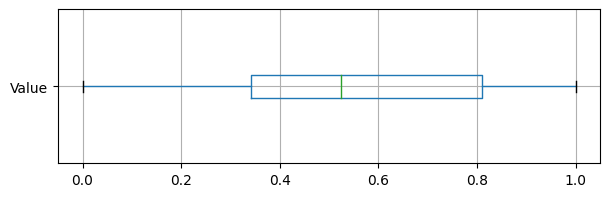

In [9]:
#check boxplot
train_scaled.boxplot(vert=False, figsize=(7, 2))
plt.show()

In [10]:
#creating a data strcutute with 60 timestamps and 1 output
X_train = []
y_train = []
train_scaled = train_scaled.to_numpy()
for i in range(60, train_scaled.size):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(f'x_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_train shape: (140, 60)
y_train shape: (140,)


In [11]:
#reshaping the data according to the input on the lstm layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(f'x_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

x_train shape: (140, 60, 1)
y_train shape: (140,)


**Explanation:** The raw data is restructured into predictor and response data with each response having a predictor of 60 timestamps. For regression problems using LSTM (Long Short-Term Memory), it is necessary to prepare data in 3D for the input layer.

## **Modelling**

### **Training with Hyperparameter Searching**

In [12]:
#make function to build model for hyperparameter searching using grid search
def Model(layer_lstm, units, dropout, optimizer, regularizer=None, regularizer_rate=0.01):
  regularizer = l2(regularizer_rate) if regularizer == 'l2' else l1(regularizer_rate) if regularizer == 'l1' else None
  model = Sequential()
  #Input layer
  model.add(Dense(units, activation='relu', input_shape=(X_train.shape[1], 1)))
  for layer in range(layer_lstm-1):
  #hidden Layer (LSTM Stack)
    model.add(LSTM(units=units, return_sequences=True, kernel_regularizer=regularizer, bias_regularizer=regularizer))
    model.add(Dropout(dropout))
  model.add(LSTM(units=units, kernel_regularizer=regularizer, bias_regularizer=regularizer))
  model.add(Dropout(dropout))
  #Output Layer
  model.add(Dense(units=1))
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
  return model

In [13]:
#prepare hyperparameter 
params = {
    'layer_lstm': [2, 3],
    'units': [200, 260],
    'dropout': [0.0, 0.25],
    'optimizer': ['adam', 'rmsprop'],
    'regularizer': [None, 'l2'],
}

#function for grid search
def GridSearch(X, y, fn_model, params, epochs, batch_size, callbacks=None, verbose=1):
  candidates = [dict(zip(params.keys(), c)) for c in list(product(*params.values()))]
  print(f'Fitting for each {len(candidates)} candidates\n')
  models = {}
  for i, c in enumerate(candidates):
    model = fn_model(**c)
    print(("-"*110), f'\nModel: {i+1} - params: {c}')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
    loss, mse = model.evaluate(X, y)
    models[f'Model_{i+1}'] = {'params' : c, 'model' : model, 'loss' : loss, 'mse' : mse,}
  print("-"*100)
  return models

#define early stopping for reduce time when fitting model
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

#start fitting grid search
start = time.time()
models = GridSearch(X_train, y_train, Model, params, epochs=100, batch_size=42, callbacks=[es], verbose=0)
print(f'\nExecution Time: {round((time.time() - start)/60, 2)} min')

Fitting for each 32 candidates

-------------------------------------------------------------------------------------------------------------- 
Model: 1 - params: {'layer_lstm': 2, 'units': 200, 'dropout': 0.0, 'optimizer': 'adam', 'regularizer': None}
5/5 [==============================] - 1s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034
-------------------------------------------------------------------------------------------------------------- 
Model: 2 - params: {'layer_lstm': 2, 'units': 200, 'dropout': 0.0, 'optimizer': 'adam', 'regularizer': 'l2'}
5/5 [==============================] - 1s 9ms/step - loss: 1.6422 - mean_squared_error: 0.0080
-------------------------------------------------------------------------------------------------------------- 
Model: 3 - params: {'layer_lstm': 2, 'units': 200, 'dropout': 0.0, 'optimizer': 'rmsprop', 'regularizer': None}
Epoch 15: early stopping
5/5 [==============================] - 1s 7ms/step - loss: 0.0103 - mean_squared_error:

In [14]:
#view the results of a grid search
df_models = pd.DataFrame(models).transpose()
df_models

,params,model,loss,mse
Model_1,"{'layer_lstm': 2, 'units': 200, 'dropout': 0.0...",<keras.engine.sequential.Sequential object at ...,0.003371,0.003371
Model_2,"{'layer_lstm': 2, 'units': 200, 'dropout': 0.0...",<keras.engine.sequential.Sequential object at ...,1.642196,0.008007
Model_3,"{'layer_lstm': 2, 'units': 200, 'dropout': 0.0...",<keras.engine.sequential.Sequential object at ...,0.010333,0.010333
Model_4,"{'layer_lstm': 2, 'units': 200, 'dropout': 0.0...",<keras.engine.sequential.Sequential object at ...,1.44118,0.011046
Model_5,"{'layer_lstm': 2, 'units': 200, 'dropout': 0.2...",<keras.engine.sequential.Sequential object at ...,0.006095,0.006095
Model_6,"{'layer_lstm': 2, 'units': 200, 'dropout': 0.2...",<keras.engine.sequential.Sequential object at ...,1.640492,0.0074
Model_7,"{'layer_lstm': 2, 'units': 200, 'dropout': 0.2...",<keras.engine.sequential.Sequential object at ...,0.035971,0.035971
Model_8,"{'layer_lstm': 2, 'units': 200, 'dropout': 0.2...",<keras.engine.sequential.Sequential object at ...,1.438374,0.008911
Model_9,"{'layer_lstm': 2, 'units': 260, 'dropout': 0.0...",<keras.engine.sequential.Sequential object at ...,0.006187,0.006187
Model_10,"{'layer_lstm': 2, 'units': 260, 'dropout': 0.0...",<keras.engine.sequential.Sequential object at ...,2.128472,0.008795


In [15]:
#find the best model with minimum loss
idx = 0 
loss = float(df_models[['loss']].max())
for i in range(len(df_models)):
  mse_ = df_models.iloc[i]['mse']
  loss_ =  df_models.iloc[i]['loss']
  if(mse_ == loss_):
    if(loss_ < loss):
      loss = loss_
      idx = i

print(f"idx         : {idx}")
print(f"model       : {df_models.iloc[idx].name}")
print(f"best params : {df_models.iloc[idx]['params']}")
print(f"best MSE    : {df_models.iloc[idx]['mse']}")
print(f"minimum LOSS: {df_models.iloc[idx]['loss']}")

idx         : 0
model       : Model_1
best params : {'layer_lstm': 2, 'units': 200, 'dropout': 0.0, 'optimizer': 'adam', 'regularizer': None}
best MSE    : 0.003371208906173706
minimum LOSS: 0.003371208906173706


In [16]:
#using best model
regressor = df_models.iloc[idx].model
regressor.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.003371209>,
 'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.003371209>}

**Explanation:** To find the best model, a Grid Search is performed by calling the Model() function which will later be called by the GridSearch() function with the parameters that have been prepared. In this Grid Search, do not use cross validation and directly fit the training data on the model to find the best hyperparameters with minimal loss. In addition, to reduce execution time, early stopping is also implemented with patience=10. The combination of hyperparameters used includes the number of layers LSTM, units, dropouts, optimizer, and regularizer.

### **Testing**

In [17]:
#read test data
test = pd.read_csv('TestingUSD.csv', header=None, names=['Value'])
test.head(5)

,Value
0,15450.00000
1,15489.00000
2,15472.59961
3,15409.00000
4,15372.00000


In [18]:
#setup structure test data
dataset = pd.concat((train, test), axis = 0)
inputs = dataset[len(dataset) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
print(inputs.shape)

(120, 1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [19]:
#creating a test data structure with 60 timestamps and 1 output
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
print(X_test.shape)

(60, 60)


In [20]:
#reshaping the test data according to the input on the lstm layer
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(60, 60, 1)


In [21]:
#predict the test data
pred = regressor.predict(X_test)
pred = scaler.inverse_transform(pred)
test_mse = mean_squared_error(pred, test)

2/2 [==============================] - 1s 8ms/step


Testing MSE: 7503.751831890305


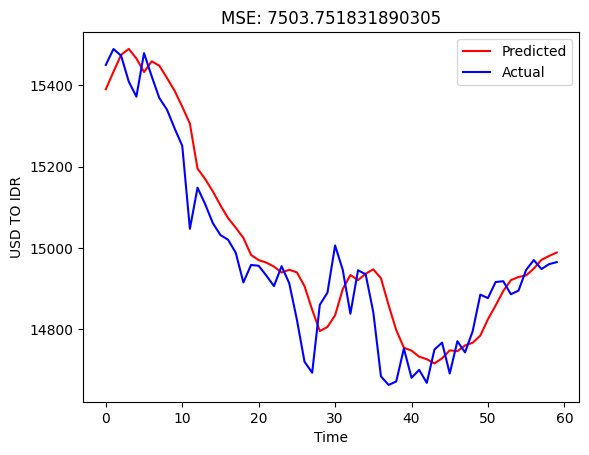

In [22]:
# Visualizing the results
print(f'Testing MSE: {test_mse}')
plt.plot(pred, color = 'red', label = 'Predicted')
plt.plot(test, color = 'blue', label = 'Actual')
plt.title(f'MSE: {test_mse}')
plt.xlabel('Time')
plt.ylabel('USD TO IDR')
plt.legend()
plt.show()

**Explanation:** After constructing the model with the lowest MSE loss score, testing will be conducted on new data from the time series that follows the training data.

## **Updating Model**


###**Retraining with Different Early Stopping & Batch**

In [23]:
#call the best model that has been trained before
re_regressor = df_models.iloc[idx].model
re_regressor.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.003371209>,
 'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.003371209>}

In [24]:
#retrain model
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=20, restore_best_weights=True, start_from_epoch=20, verbose=1)
re_regressor.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[es])

Epoch 1/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 2/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 3/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 4/100
140/140 [==============================] - 2s 11ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 5/100
140/140 [==============================] - 2s 12ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 6/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 7/100
140/140 [==============================] - 1s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 8/100
140/140 [==============================] - 1s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 9/100
140/140 [==============================] - 1s 8ms/step - loss: 0.0043 - mean_squared_error: 0.0043

In [25]:
#get_last_result
re_regressor.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0029870234>,
 'mean_squared_error': <tf.Tensor: shape=(), dtype=float32, numpy=0.0029870234>}

###**Testing**

In [26]:
#predict the test data
pred = re_regressor.predict(X_test)
pred = scaler.inverse_transform(pred)
test_mse = mean_squared_error(pred, test)

2/2 [==============================] - 0s 9ms/step


Testing MSE: 4811.099891044603


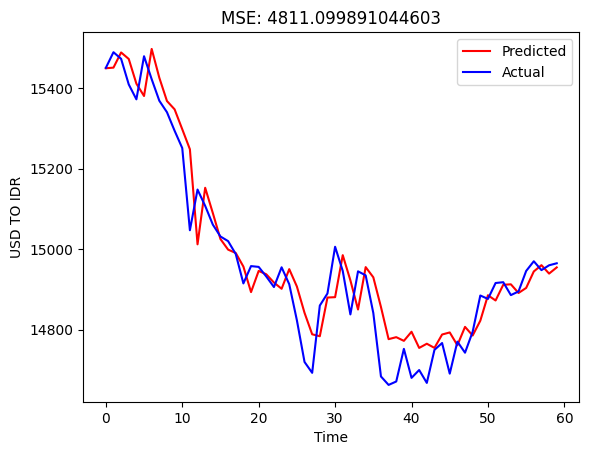

In [27]:
# Visualizing the results
print(f'Testing MSE: {test_mse}')
plt.plot(pred, color = 'red', label = 'Predicted')
plt.plot(test, color = 'blue', label = 'Actual')
plt.title(f'MSE: {test_mse}')
plt.xlabel('Time')
plt.ylabel('USD TO IDR')
plt.legend()
plt.show()

In [28]:
#best result
print(mean_squared_error(pred, test))

4811.099891044603


**Explanation:** Because the previous model being trained by searching for the best hyperparameters with some limitations to reduce execution time, a retraining process is conducted by modifying the early stopping and batch_size.